In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cm
import torch 
from astropy.io import fits


In [53]:
!pip install astropy regions

In [54]:
### Loading in the data as 2d arrays from FITS files using astropy utility


### WISE mosaics: 
wise_path = "/Users/hph/Dropbox/astrophys/IGNITES/data/IGNITES_regrid_reconvolve/wise_mosaics/"
wise_3um_data = fits.open(wise_path+'mosaic_3um_reprojected_to_500um.fits')[0].data
wise_5um_data = fits.open(wise_path+'mosaic_5um_reprojected_to_500um.fits')[0].data
wise_12um_data = fits.open(wise_path+'mosaic_12um_reprojected_to_500um.fits')[0].data
wise_22um_data = fits.open(wise_path+'mosaic_22um_reprojected_to_500um.fits')[0].data


### Other mosaic data path:
ignites_path = "/Users/hph/Dropbox/astrophys/IGNITES/data/IGNITES_regrid_reconvolve/"

### Spitzer mosaics:
spitzer_8um_data = fits.open(ignites_path+"mosaic_8um_reprojected_to_500um.fits")[0].data
spitzer_24um_data = fits.open(ignites_path+"mosaic_24um_reprojected_to_500um.fits")[0].data

### Herschel mosaics:
herschel_70um_data = fits.open(ignites_path+"mosaic_70um_reprojected_to_500um.fits")[0].data
herschel_160um_data = fits.open(ignites_path+"mosaic_160um_reprojected_to_500um.fits")[0].data
herschel_250um_data = fits.open(ignites_path+"mosaic_250um_reprojected_to_500um.fits")[0].data
herschel_500um_data = fits.open(ignites_path+"mosaic_500um_reprojected_to_500um.fits")[0].data

image_shape = spitzer_8um_data.shape
print(spitzer_8um_data.shape)


(2800, 19000)


In [55]:
import numpy as np

def normalize_flux(data):
    """
    Normalize an image while preserving astrophysical structures.

    Parameters:
    - data (numpy.ndarray): A 2D array  
      where each slice represents a flux map in a different wavelength band.

    Returns:
    - normalized_cube (numpy.ndarray): The normalized image cube.
    """

    ### Apply log scaling to preserve dynamic range during normalization
    ### Adding 1 to avoid log(0) issues, as flux values may include zeroes
    log_data = np.log1p(data)  

    ### Compute the mean and standard deviation of the data
    ### This ensures that different wavelengths are treated comparably (should we do this)
    mean_data = np.mean(log_data)
    std_data = np.std(log_data) 

    ### Z-score normalization
    ### This standardizes the log-transformed flux values to have mean=0 and std=1 per band
    normalized_data = (log_data - mean_data) / std_data

    return normalized_data



In [70]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from regions import Regions, PixCoord, EllipsePixelRegion

def ds9_to_mask(ds9_file, fits_header, image_shape):
    """
    Convert a DS9 region file into a binary mask matching the image shape.

    Parameters:
    - ds9_file (str): Path to the DS9 region file containing YSO or point source locations.
    - fits_header (astropy.io.fits.Header): The FITS header with WCS information.
    - image_shape (tuple): Shape of the image (height, width).

    Returns:
    - mask (numpy.ndarray): Binary mask of the same shape as the image, with 1s at source locations.
    """

    # Read DS9 region file using updated method
    regions = Regions.read(ds9_file, format="ds9")

    # Convert WCS from header
    wcs = WCS(fits_header)

    # Initialize mask
    mask = np.zeros(image_shape, dtype=float)

    for region in regions:
        if hasattr(region, 'center'):
            # Convert world coordinates to pixel coordinates
            pix_center = wcs.world_to_pixel(region.center)
            pix_radius = 20

            # Ensure pixel coordinates are within the image bounds
            if 0 <= pix_center[0] < image_shape[1] and 0 <= pix_center[1] < image_shape[0]:
                # Create an elliptical mask
                ellipse = EllipsePixelRegion(PixCoord(*pix_center), pix_radius, pix_radius)
                #print(np.where(ellipse.to_mask().to_image(image_shape)))
                mask += ellipse.to_mask().to_image(image_shape,dtype=float)  # Overlay mask

    mask[np.where(mask!=0)] = 1
    return mask



In [75]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from regions import Regions
from scipy.ndimage import binary_dilation

def ds9_to_mask_optimized(ds9_file, fits_header, image_shape, radius=20):
    """
    Convert a DS9 region file into a binary mask efficiently.

    Parameters:
    - ds9_file (str): Path to the DS9 region file.
    - fits_header (astropy.io.fits.Header): The FITS header for WCS conversion.
    - image_shape (tuple): (height, width) of the image.
    - radius (int): Pixel radius for marking sources.

    Returns:
    - mask (numpy.ndarray): Binary mask.
    """

    # Read DS9 region file
    regions = Regions.read(ds9_file, format="ds9")

    # Convert WCS from header
    wcs = WCS(fits_header)

    # Initialize binary mask
    mask = np.zeros(image_shape, dtype=bool)

    # Convert all source coordinates to pixel coordinates at once
    pix_coords = [wcs.world_to_pixel(region.center) for region in regions if hasattr(region, 'center')]
    pix_coords = np.array(pix_coords).T  # Convert list to numpy array

    # Filter out any coordinates that are out of bounds
    valid_idx = (pix_coords[0] >= 0) & (pix_coords[0] < image_shape[1]) & \
                (pix_coords[1] >= 0) & (pix_coords[1] < image_shape[0])

    # Apply valid indices
    pix_x, pix_y = pix_coords[:, valid_idx].astype(int)

    # Mark pixels where tracers are present
    mask[pix_y, pix_x] = True

    # Expand sources to the desired radius using binary dilation
    structuring_element = np.ones((2 * radius + 1, 2 * radius + 1), dtype=bool)
    mask = binary_dilation(mask, structure=structuring_element)

    return mask.astype(np.uint8)  # Convert to 0-1 integer mask



In [71]:
### using poorly optimized code that runs as expected
region_path = "/Users/hph/Dropbox/astrophys/IGNITES/sf_tracer_regions/"
region_file = "molinari_2016_70micron.reg"
header = fits.getheader(ignites_path+"mosaic_8um_reprojected_to_500um.fits")
image_shape =  spitzer_8um_data.shape
mask = ds9_to_mask(region_path+region_file, header, image_shape)

In [76]:
### untested optimized code to make mask
region_path = "/Users/hph/Dropbox/astrophys/IGNITES/sf_tracer_regions/"
region_file = "molinari_2016_70micron.reg"
header = fits.getheader(ignites_path+"mosaic_8um_reprojected_to_500um.fits")
image_shape =  spitzer_8um_data.shape
mask_opt = ds9_to_mask_optimized(region_path+region_file, header, image_shape)

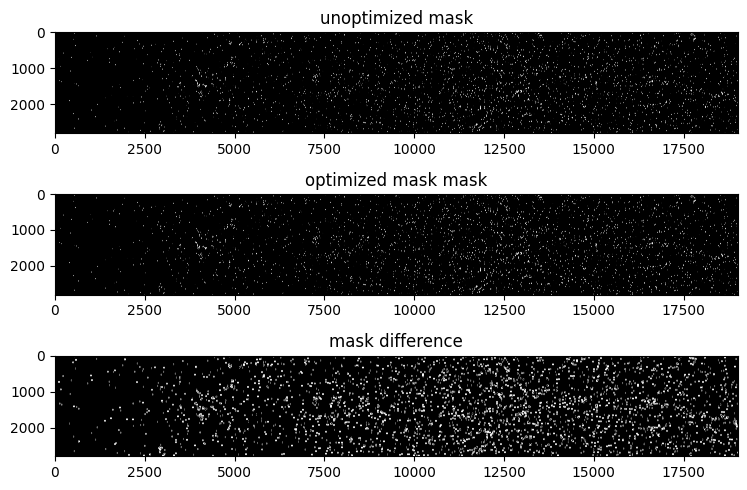

In [80]:
### visualize masks for comparison
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (14,5))

ax = axes[0]
ax.imshow(mask,cmap = cm.neutral)
ax.set_title("unoptimized mask")

ax = axes[1]
ax.imshow(mask,cmap = cm.neutral)
ax.set_title("optimized mask mask")

ax = axes[2]
ax.imshow(np.abs(mask-mask_opt),cmap = cm.neutral)
ax.set_title("mask difference")

plt.tight_layout()
plt.show()


In [81]:
np.save(region_path+'mask_molinari_70um_ptsrc', mask)
np.save(region_path+'mask_opt_molinari_70um_ptsrc', mask)

In [33]:
### Now let's normalize the data with log-scale and z-score normalization

### WISE mosaics: 
wise_3um_norm = normalize_flux(wise_3um_data)
wise_5um_norm = normalize_flux(wise_5um_data)
wise_12um_norm = normalize_flux(wise_12um_data)
wise_22um_norm = normalize_flux(wise_22um_data)

### Spitzer mosaics:
spitzer_8um_norm = normalize_flux(spitzer_8um_data)
spitzer_24um_norm = normalize_flux(spitzer_24um_data)

### Herschel mosaics:
herschel_70um_norm = normalize_flux(herschel_70um_data)
herschel_160um_norm = normalize_flux(herschel_160um_data)
herschel_250um_norm = normalize_flux(herschel_250um_data)
herschel_500um_norm = normalize_flux(herschel_500um_data)

/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_91370/33132519.py:17: RuntimeWarning: invalid value encountered in log1p
  log_data = np.log1p(data)


In [82]:

def prepare_training_data(flux_maps, mask):
    """
    Converts multi-wavelength flux maps and a binary mask into a structured dataset.

    Parameters:
    - flux_maps (numpy.ndarray): Shape (num_bands, height, width), multi-band image data.
    - mask (numpy.ndarray): Shape (height, width), binary mask of YSO locations.

    Returns:
    - X (numpy.ndarray): Feature matrix of shape (num_pixels, num_features).
    - y (numpy.ndarray): Binary labels of shape (num_pixels,).
    """
    num_bands, height, width = flux_maps.shape
    
    # Flatten the images: (num_pixels, num_bands)
    X = flux_maps.reshape(num_bands, -1).T  # Transpose to get (num_pixels, num_features)
    
    # Flatten the binary mask to match pixel indices
    y = mask.flatten()  

    return X, y


In [84]:
### stack the flux data into a big numpy array for processing
flux_maps_array = np.array([wise_3um_norm,
                           wise_5um_norm,
                           wise_12um_norm,
                           wise_22um_norm,
                           spitzer_8um_norm,
                           spitzer_24um_norm,
                           herschel_70um_norm,
                           herschel_160um_norm,
                           herschel_250um_norm,
                           herschel_500um_norm])
### use the data preparation function to structure flux maps into a feature matrix
X_complete, y_complete = prepare_training_data(flux_maps_array, mask_opt)

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_random_forest(X, y):
    """
    Trains a Random Forest classifier on the given dataset.

    Parameters:
    - X (numpy.ndarray): Feature matrix.
    - y (numpy.ndarray): Binary labels.

    Returns:
    - model (RandomForestClassifier): Trained classifier.
    - metrics (dict): Accuracy, precision, recall, F1-score.
    """

    # Split into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Initialize Random Forest
    model = RandomForestClassifier(
        n_estimators=100,  # Number of trees in the forest
        max_depth=10,  # Maximum depth of each tree (prevents overfitting)
        random_state=42,  # Ensures reproducibility
        n_jobs=-1  # Use all available CPU cores
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
    }

    return model, metrics


In [ ]:
rf_model, rf_metrics = train_random_forest(X_complete, y_complete)

# Print performance metrics
print(rf_metrics)